## Оглавление:

* [1. Обзор данных](#обзор_данных)
* [2. Предобработка данных](#предобработка_данных)
    * [2.1. Удаление пропусков](#удаление_пропусков)
    * [2.2. Обработка аномальных значений](#обработка_аномальных_значений)
    * [2.3. Обработка дубликатов](#обработка_дубликатов)
    * [2.4. Категоризация данных](#категоризация_данных)
* [3. Проверка гипотез](#проверка_гипотез)  (Оценка влияния на своевременный возврат кредита следующих факторов):
    * [3.1. Количество детей](#дети)
    * [3.2. Семейное положение](#семья)
    * [3.3. Возраст заемщика](#возраст)
    * [3.4. Уровень заработка](#доход)
    * [3.5. Цель получения кредита](#цель)
* [4. Итоги исследования](#итоги_исследования)

# Исследование надежности заемщиков

**Цель исследования** - Оценка критериев кредитополучателей, по которым возможно предсказать вероятность своевременного погашения займа.
  
**Основные гипотезы** - Надежность заемщика может зависеть от таких критериев как уровень заработка, возраст, семейное положение или наличие детей. Также своевременность выплаты может зависеть от цели, на которую берется кредит.
  
**Ход исследования** - Данные о поведении пользователей получены из файла с расширением .csv. 
Имеется документация, однако могут встречаться пропуски или значения, искажающие данные. Поэтому перед проверкой гипотез требуется провести обзор данных.


## 1. Обзор данных <a class="anchor" id="обзор_данных"></a>

В исследовании используются средства библиотеки `pandas`.
Данные получены в виде файла с расширением .csv

In [1]:
import pandas as pd

data = pd.read_csv('loan_data.csv')

Для общего представления о полученных данных осуществляется вывод первых 5-ти строк таблицы:

In [2]:
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


Также оценивается общая информация о таблице:

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


**Согласно документации:**
    
`children` — количество детей в семье  
`days_employed` — общий трудовой стаж в днях  
`dob_years` — возраст клиента в годах  
`education` — уровень образования клиента  
`education_id` — идентификатор уровня образования  
`family_status` — семейное положение  
`family_status_id` — идентификатор семейного положения  
`gender` — пол клиента  
`income_type` — тип занятости  
`debt` — имел ли задолженность по возврату кредитов  
`total_income` — ежемесячный доход  
`purpose` — цель получения кредита  

## 2. Предобработка данных <a class="anchor" id="предобработка_данных"></a>

### 2.1 Удаление пропусков <a class="anchor" id="удаление_пропусков"></a>

Количество пропущенных значений для каждого столбца:

In [4]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Необходимо заполнить пропуски в столбце `total_income` с данными о доходах.  
На сумму дохода сильнее всего влияет тип занятости, поэтому заполнить пропуски в этом столбце следует медианным значением по каждому типу из столбца `income_type`.

In [5]:
for t in data['income_type'].unique():
    data.loc[(data['income_type'] == t) & (data['total_income'].isna()), 'total_income'] = \
    data.loc[(data['income_type'] == t), 'total_income'].median()

Проверка заполнения пропусков:

In [6]:
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income           0
purpose                0
dtype: int64

Поскольку столбец `days_employed` не понадобится для исследования, на данный момент нет необходимости заполнять пропуски в нем.

### 2.2 Обработка аномальных значений <a class="anchor" id="обработка_аномальных_значений"></a>

Проверка значений столбца `children`.

In [9]:
data['children'].unique()

array([ 1,  0,  3,  2, -1,  4, 20,  5], dtype=int64)

В столбце `children` есть два аномальных значения. Строки, в которых встречаются аномальные значения исключаются из датафрейма `data`.

In [10]:
data = data[(data['children'] != -1) & (data['children'] != 20)]

Проверка уникальных значений столбца `children`, чтобы убедиться, что артефакты удалены.

In [11]:
data['children'].unique()

array([1, 0, 3, 2, 4, 5], dtype=int64)

Для удобства визуализации также следует заменить вещественный тип данных в столбце `total_income` на целочисленный

In [12]:
data['total_income'] = data['total_income'].astype(int)

### 2.3. Обработка дубликатов <a class="anchor" id="обработка_дубликатов"></a>

**Задание 14. Обработайте неявные дубликаты в столбце `education`. В этом столбце есть одни и те же значения, но записанные по-разному: с использованием заглавных и строчных букв. Приведите их к нижнему регистру. Проверьте остальные столбцы.**

In [13]:
data['education'] = data['education'].str.lower()

**Задание 15. Выведите на экран количество строк-дубликатов в данных. Если такие строки присутствуют, удалите их.**

In [14]:
data.duplicated().sum()

71

In [15]:
data = data.drop_duplicates()

### 2.4. Категоризация данных <a class="anchor" id="категоризация_данных"></a>

**Задание 16. На основании диапазонов, указанных ниже, создайте в датафрейме `data` столбец `total_income_category` с категориями:**

- 0–30000 — `'E'`;
- 30001–50000 — `'D'`;
- 50001–200000 — `'C'`;
- 200001–1000000 — `'B'`;
- 1000001 и выше — `'A'`.


**Например, кредитополучателю с доходом 25000 нужно назначить категорию `'E'`, а клиенту, получающему 235000, — `'B'`. Используйте собственную функцию с именем `categorize_income()` и метод `apply()`.**

In [16]:
def categorize_income(income):
    try:
        if 0 <= income <= 30000:
            return 'E'
        elif 30001 <= income <= 50000:
            return 'D'
        elif 50001 <= income <= 200000:
            return 'C'
        elif 200001 <= income <= 1000000:
            return 'B'
        elif income >= 1000001:
            return 'A'
    except:
        pass

In [17]:
data['total_income_category'] = data['total_income'].apply(categorize_income)

**Задание 17. Выведите на экран перечень уникальных целей взятия кредита из столбца `purpose`.**

In [18]:
data['purpose'].unique()

array(['покупка жилья', 'приобретение автомобиля',
       'дополнительное образование', 'сыграть свадьбу',
       'операции с жильем', 'образование', 'на проведение свадьбы',
       'покупка жилья для семьи', 'покупка недвижимости',
       'покупка коммерческой недвижимости', 'покупка жилой недвижимости',
       'строительство собственной недвижимости', 'недвижимость',
       'строительство недвижимости', 'на покупку подержанного автомобиля',
       'на покупку своего автомобиля',
       'операции с коммерческой недвижимостью',
       'строительство жилой недвижимости', 'жилье',
       'операции со своей недвижимостью', 'автомобили',
       'заняться образованием', 'сделка с подержанным автомобилем',
       'получение образования', 'автомобиль', 'свадьба',
       'получение дополнительного образования', 'покупка своего жилья',
       'операции с недвижимостью', 'получение высшего образования',
       'свой автомобиль', 'сделка с автомобилем',
       'профильное образование', 'высшее об

**Задание 18. Создайте функцию, которая на основании данных из столбца `purpose` сформирует новый столбец `purpose_category`, в который войдут следующие категории:**

- `'операции с автомобилем'`,
- `'операции с недвижимостью'`,
- `'проведение свадьбы'`,
- `'получение образования'`.

**Например, если в столбце `purpose` находится подстрока `'на покупку автомобиля'`, то в столбце `purpose_category` должна появиться строка `'операции с автомобилем'`.**

**Используйте собственную функцию с именем `categorize_purpose()` и метод `apply()`. Изучите данные в столбце `purpose` и определите, какие подстроки помогут вам правильно определить категорию.**

In [19]:
def categorize_purpose(row):
    try:
        if 'автом' in row:
            return 'операции с автомобилем'
        elif 'жил' in row or 'недвиж' in row:
            return 'операции с недвижимостью'
        elif 'свад' in row:
            return 'проведение свадьбы'
        elif 'образов' in row:
            return 'получение образования'
    except:
        return 'нет категории'

In [20]:
data['purpose_category'] = data['purpose'].apply(categorize_purpose)

### 3. Проверка гипотез <a class="anchor" id="проверка_гипотез"></a>

#### 3.1 Есть ли зависимость между количеством детей и возвратом кредита в срок? <a class="anchor" id="дети"></a>

Для проверки данной гипотезы необходимы следующие действия:  
1. Группировка всех кредиторов по количеству детей
2. Оценка вероятности возникновения просрочки по кредиту как отношения кредитов с задолженностью ко всем взятым кредитам
3. Составление графика зависимости и его анализ

In [21]:
debt_probability_by_children = data.groupby('children')

print(debt_probability_by_children['debt'].mean()) #разделение кредиторов по кол-ву детей

children
0    0.075438
1    0.092346
2    0.094542
3    0.081818
4    0.097561
5    0.000000
Name: debt, dtype: float64


По предварительной оценке значения близки и не имеют четкой зависимости. Однако, среди семей с пятью детьми все кредиты были возвращены в срок. Необходимо проверить причину настолько значительного отклонения.

In [22]:
print(debt_probability_by_children['debt'].count()) #оценка репрезентативности выборки

children
0    14091
1     4808
2     2052
3      330
4       41
5        9
Name: debt, dtype: int64


Причина отклонений заключается в том, что данных для оценки вероятности невыплаты кредита в срок для многодетных семей недостаточно, поэтому семьи с четырьмя и пятью детьми необходимо исключить из расчета.

In [23]:
debt_probability_by_children_mean = debt_probability_by_children['debt'].mean()[0:4]

print(round(debt_probability_by_children_mean, 3)) #для каждой группы посчитать процент задолженностей (среднее значение)

children
0    0.075
1    0.092
2    0.095
3    0.082
Name: debt, dtype: float64


На основании этих данных построен график зависимости

<AxesSubplot:xlabel='children', ylabel='debt'>

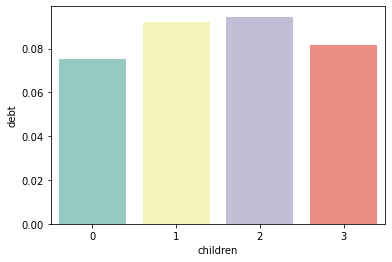

In [24]:
import seaborn as sns
                            #график отношения кол-ва детей к вероятности наличия задолженности
sns.barplot(x=debt_probability_by_children_mean.index, 
            y=debt_probability_by_children_mean,
            palette = 'Set3')

Визуально данные не имеют тенденции, однако требуется более точная оценка. 

In [25]:
res = data.pivot_table(index='children', 
                       values='debt', 
                       aggfunc=['count', 'sum', 'mean'])
res.columns = ['Всего выдано кредитов', 'Просрочено кредитов', 'Вероятность просрочки']
res[0:4].round(3)

,Всего выдано кредитов,Просрочено кредитов,Вероятность просрочки
children,,,
0,14091,1063,0.075
1,4808,444,0.092
2,2052,194,0.095
3,330,27,0.082


**Вывод:** 

В результате анализа не выявлено тенденции к изменению количества задолженностей по кредиту в зависимости от количества детей в семье кредитора. Все значения находятся в диапазоне 7,5% - 9,5% просроченных кредитов и не имеют заметной тенденции. 
  
Однако следует обратить внимание на то, что по объективным причинам данных для анализа семей с четырья и пятью детьми недостаточно и расчеты к ним не применялись.

#### 3.2 Есть ли зависимость между семейным положением и возвратом кредита в срок? <a class="anchor" id="семья"></a>

Для проверки второй гипотезы необходимо использовать аналогичный порядок действий:  
1. Все кредиторы группируются по семейному положению
2. Оценивается вероятность возникновения просрочки по кредиту
3. Составляется и анализируется график зависимости

In [26]:
debt_probability_by_family_status = data.groupby('family_status')

print(debt_probability_by_family_status['debt'].mean()) #группировка кредиторов по гражданскому состоянию
print()
print(debt_probability_by_family_status['debt'].count()) #оценка репрезентативности выборки

family_status
Не женат / не замужем    0.097639
в разводе                0.070648
вдовец / вдова           0.066246
гражданский брак         0.093130
женат / замужем          0.075606
Name: debt, dtype: float64

family_status
Не женат / не замужем     2796
в разводе                 1189
вдовец / вдова             951
гражданский брак          4134
женат / замужем          12261
Name: debt, dtype: int64


Ошибки в данных не обнаружены, а данных достаточно для анализа 
Следующим этапом является построение графика
Для удобства визуализации график построен по `family_status_id`, а также приложена легенда.

family_status
Не женат / не замужем    4.0
в разводе                3.0
вдовец / вдова           2.0
гражданский брак         1.0
женат / замужем          0.0
Name: family_status_id, dtype: float64


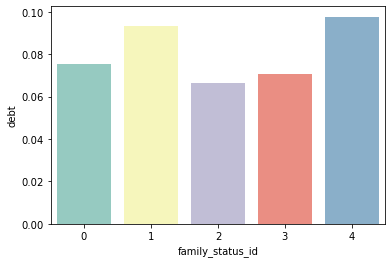

In [27]:
debt_probability_by_family_status_id = data.groupby('family_status_id')

debt_probability_by_family_status_id_mean = debt_probability_by_family_status_id['debt'].mean()

sns.barplot(x=debt_probability_by_family_status_id_mean.index, 
            y=debt_probability_by_family_status_id_mean,
            palette = 'Set3')
                            #график отношения гражданского положения к вероятности наличия задолженности
print(data.groupby('family_status')['family_status_id'].mean())

Заметно, что люди, находящиеся в разводе или потерявшие супруга реже имеют задолженности по кредитам, в то время как граждане, не находившиеся в браке наоборот, чаще задерживают оплату.

In [28]:
res = data.pivot_table(index='family_status', 
                       values='debt', 
                       aggfunc=['count', 'sum', 'mean'])
res.columns = ['Всего выдано кредитов', 'Просрочено кредитов', 'Вероятность просрочки']
res.round(3)

,Всего выдано кредитов,Просрочено кредитов,Вероятность просрочки
family_status,,,
Не женат / не замужем,2796,273,0.098
в разводе,1189,84,0.071
вдовец / вдова,951,63,0.066
гражданский брак,4134,385,0.093
женат / замужем,12261,927,0.076


**Промежуточный вывод:** 

Гипотеза частично подтверждена, поскольку наблюдается закономерность, что люди, имеющие статус `в разводе` и `вдовы/вдовцы` чаще возвращают кредиты в срок, в то время как категория граждан `холост / не замужем` имеет больший процент просрочек.
  
Возможно, на вероятность возврата кредита в срок влияет возраст, а не семейное положение, т.к. люди категорий `в разводе` и `вдова / вдовец` скорее всего старше, а категория `холост / не замужем` наоборот, потенциально самая "молодая".

Необходима проверка дополнительной гипотезы, путем нахождения среднего возраста каждой категории:

#### 3.3 Есть ли зависимость между возрастом и возвратом кредита в срок? <a class="anchor" id="возраст"></a>

In [29]:
display(debt_probability_by_family_status['dob_years','debt'].mean().round(3))

C:\Users\1\AppData\Local\Temp\ipykernel_3964\1674298435.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  display(debt_probability_by_family_status['dob_years','debt'].mean().round(3))


,dob_years,debt
family_status,,
Не женат / не замужем,38.368,0.098
в разводе,45.562,0.071
вдовец / вдова,56.502,0.066
гражданский брак,42.068,0.093
женат / замужем,43.559,0.076


Категории заемщиков с более низким процентом просрочек действительно имеют наибольший средний возраст.
Поэтому следует рассмотреть данную гипотезу подробнее:
Для удобства оценки проводится группировка заемщиков по возрасту и проверка вероятность невыплаты кредита для каждой категории

In [30]:
def age_category (age):  #функция распределения возрастов по категориям, где A - наименьший возраст, F - наибольший
    if age >=70:
        return '70+'
    if age >=60:
        return '60-69'
    if age >=50:
        return '50-59'
    if age >=40:
        return '40-49'
    if age >=30:
        return '30-39'
    return '0-29'

data['dob_years_category'] = data['dob_years'].apply(age_category)

<AxesSubplot:xlabel='dob_years_category', ylabel='debt'>

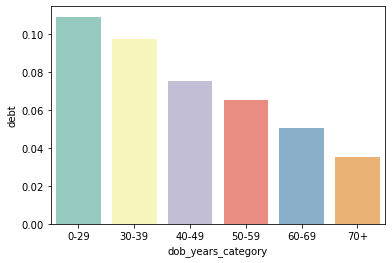

In [31]:
sns.barplot(x=data.groupby('dob_years_category')['debt'].mean().index, 
            y=data.groupby('dob_years_category')['debt'].mean(), 
            palette = 'Set3')
#график зависимости количества просроченных кредитов от возраста заемщика

Заметна явная тенденция к повышению стабильности выплат с увеличением возраста кредитора

**Вывод:** 

Зависимость вероятности возникновения задержек по кредиту от семейного положения проявляется косвено.  
На результат большее влияние оказывает возраст заемщика, а не его семейное положение.

#### 3.4 Есть ли зависимость между уровнем дохода и возвратом кредита в срок? <a class="anchor" id="доход"></a>

Для проверки третьей гипотезы необходимо использовать аналогичный порядок действий:  
1. Все кредиторы группируются по уровню дохода согласно категориям, определенным выше
2. Оценивается вероятность возникновения просрочки по кредиту
3. Составляется и анализируется график зависимости

In [32]:
debt_probability_by_income = data.groupby('total_income_category')

debt_probability_by_income_mean = debt_probability_by_income['debt'].mean()


print(debt_probability_by_income_mean) #разделение кредиторов по категории заработка

total_income_category
A    0.080000
B    0.070602
C    0.084982
D    0.060172
E    0.090909
Name: debt, dtype: float64


На основании этих данных строится график зависимости

<AxesSubplot:xlabel='total_income_category', ylabel='debt'>

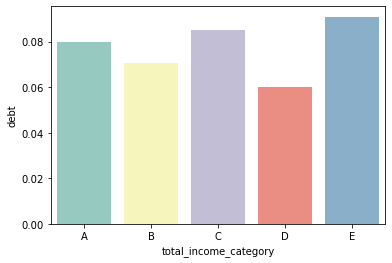

In [33]:
import seaborn as sns

sns.barplot(x=debt_probability_by_income_mean.index, 
            y=debt_probability_by_income_mean,
            palette = 'Set3')
#график отношения категории заработка к вероятности наличия задолженности

Согласно графику можно сделать вывод об отсутствии корреляции между уровнем заработка и невыплатой кредита в срок

**Вывод:** 

В результате анализа не было выявлено тенденции к изменению количества задолженностей по кредиту в зависимости от заработка.

#### 3.5 Как разные цели кредита влияют на его возврат в срок?  <a class="anchor" id="цель"></a>

Для проверки четвертой гипотезы необходимо использовать аналогичный порядок действий:  
1. Все кредиторы группируются по цели займа
2. Оценивается вероятность возникновения просрочки
3. Составляется и анализируется график зависимости

In [34]:
debt_probability_by_purpopse = data.groupby('purpose_category')
debt_probability_by_purpopse_mean = debt_probability_by_purpopse['debt'].mean()

print(debt_probability_by_purpopse_mean) #разделение кредиторов по цели получения займа

purpose_category
операции с автомобилем      0.093480
операции с недвижимостью    0.072551
получение образования       0.092528
проведение свадьбы          0.079118
Name: debt, dtype: float64


На основании этих данных строится график зависимости

<AxesSubplot:xlabel='purpose_category', ylabel='debt'>

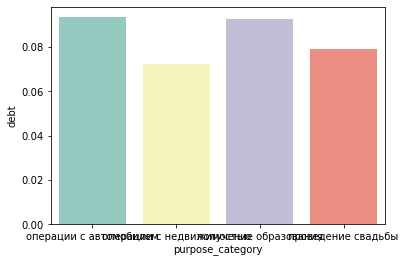

In [35]:
import seaborn as sns

sns.barplot(x=debt_probability_by_purpopse_mean.index, 
            y=debt_probability_by_purpopse_mean,
            palette = 'Set3')
#график отношения цели получения займа к вероятности возникновения задолженности

In [36]:
print(f" Чаще всего, в {debt_probability_by_purpopse_mean.max():.1%} случаев просрочки возникают по кредитам, полученным на {debt_probability_by_purpopse_mean.idxmax()}")
print(f" Реже всего, в {debt_probability_by_purpopse_mean.min():.1%} случаев просрочки возникают по кредитам, полученным на {debt_probability_by_purpopse_mean.idxmin()}")

 Чаще всего, в 9.3% случаев просрочки возникают по кредитам, полученным на операции с автомобилем
 Реже всего, в 7.3% случаев просрочки возникают по кредитам, полученным на операции с недвижимостью


**Вывод:** 

Гипотеза частично подтверждена, т.к. наблюдается зависимость вероятности возникновения задолженности по кредиту от целей получения займа.
Тем не менее, значения для различных категорий близкие, поэтому корреляция незначительная.

#### 3.5 Приведите возможные причины появления пропусков в исходных данных.

Основные причины неполноты данных - это в первую очередь необязательность внесения всех данных пользователем при заполнении, а также возможна потеря части данных при записи, хранении, экспорте и других операциях

#### 3.6 Объясните, почему заполнить пропуски медианным значением — лучшее решение для количественных переменных.

При обработке количественных переменных в первую очередь следует обращать внимание на область их значений. В случае, если значения близки допускается заполнение пробусков средним значением. Однако при наличии значений, сильно отличающихся от большинства рекомендуется использовать медианное значение во избежание смещения средних значений в большую или меньшую сторону.
  
Также следует обратить внимание, что в ряде случаев перед заполнением пропусков требуется провести группировку данных по определенным признакам.

### 4. Итоги исследования  <a class="anchor" id="итоги_исследования"></a>

Целью исследования было определение факторов, оказывающих наибольшее влияние на вероятность невыплаты кредита в срок

Для повышения точности исследования данные были доработаны следующим образом:
1. Заполнены или исключены из расчета пропущенные значения
2. Исправлены аномальные значения
3. Обработаны дубликаты
4. Данные категоризированы
  
Затем были проверены основные возможные факторы, потенциально влияющие на возникновение просрочек по кредиту:
1. Количество детей
2. Семейное положение
3. Возраст заемщика
4. Уровень заработка
5. Цель получения кредита
  
Согласно полученным данным, наибольшее влияние на своевременность выплаты кредита оказывает возраст заемщика. Заметна явная тенденция к повышению стабильности выплат с увеличением возраста кредитора
В связи с этим, косвенно на своевременность выплат влияет и гражданское положение.
  
Также имеется зависимость от целей получения кредита: займы, полученные на операции с недвижимостью чаще выплачиваются без задержек, в то время как кредиты на операции с автомобилем наименее надежны.

Гипотезы о зависимости своевременной выплаты кредита от количества детей в семье заемщика и уровня его